# Copyright Netherlands eScience Center <br>
** Function     : atmospheric meridional energy transport ERA-Interim** <br>
** Author       : Yang Liu ** <br>
** First Built  : 2019.04.06 ** <br>
** Last Update  : 2019.04.06 ** <br>
Description     : The code aims to postprocess the output from the HPC cloud
                  regarding the computation of atmospheric meridional energy
                  transport based on atmospheric reanalysis dataset ERA-Interim
                  from ECMWF. The complete procedure includes data extraction and
                  making plots.<br>

Return Value    : NetCFD4 data file<br>
Dependencies    : os, time, numpy, netCDF4, sys, matplotlib, logging<br>
variables       : Absolute Temperature              T<br>
                  Specific Humidity                 q<br>
                  Logarithmic Surface Pressure      lnsp<br>
                  Zonal Divergent Wind              u<br>
                  Meridional Divergent Wind         v<br>
                  Surface geopotential              z<br>
Caveat!!        : Spatial and temporal coverage<br>
                  Atmosphere<br>
                  ERA-Interim   1979 - 2016<br>
                  MERRA2        1980 - 2016<br>
                  JRA55         1979 - 2015<br>
                  Ocean<br>
                  GLORYS2V3     1993 - 2014<br>
                  ORAS4         1958 - 2014<br>
                  SODA3         1980 - 2015<br>
                  NEMO ORCA0083 1979 - 2012<br>
                  The full dataset of ORAS4 is from 1958. However, a quality report from
                  Magdalena from ECMWF indicates the quality of data for the first
                  two decades are very poor. Hence we use the data from 1979. which
                  is the start of satellite era.<br>
                  The full dataset of ORAS4 is from 1958.<br>
                  Data from 20N - 90N are taken into account!<br>

In [5]:
import numpy as np
import time as tttt
from netCDF4 import Dataset,num2date
import os
import platform
import logging
import matplotlib.pyplot as plt

In [2]:
# specify data path
#datapath = '/home/yang/workbench/Core_Database_AMET_OMET_reanalysis/ERAI/postprocessing'
datapath = '/home/ESLT0068/WorkFlow/Core_Database_AMET_OMET_reanalysis/ERAI/postprocessing'
# specify output path for the netCDF4 file
#output_path = '/home/yang/NLeSC/PhD/Paperwork/Article/AMET_OMET/figures'
output_path = '/home/ESLT0068/NLeSC/PhD/Paperwork/Article/AMET_OMET/ESD/figures'
Lat_num = 60

In [3]:
# zonal integral
dataset = Dataset(datapath + os.sep + 'model_daily_075_1979_2016_E_zonal_int.nc')
# spacial distribution
dataset_point = Dataset(datapath + os.sep + 'model_daily_075_1979_2016_E_point.nc')

# zonal integral
E = dataset.variables['E'][:]
E_internal = dataset.variables['E_cpT'][:]
E_latent = dataset.variables['E_Lvq'][:]
E_geopotential = dataset.variables['E_gz'][:]
E_kinetic = dataset.variables['E_uv2'][:]

# spacial distribution
E_point = dataset_point.variables['E'][:]
#E_point_internal = dataset_point.variables['E_cpT'][:]
#E_point_latent = dataset_point.variables['E_Lvq'][:]
#E_point_geopotential = dataset_point.variables['E_gz'][:]
#E_point_kinetic = dataset_point.variables['E_uv2'][:]

year = dataset.variables['year'][:]
month = dataset.variables['month'][:]
latitude = dataset.variables['latitude'][:]
longitude = dataset_point.variables['longitude'][:]

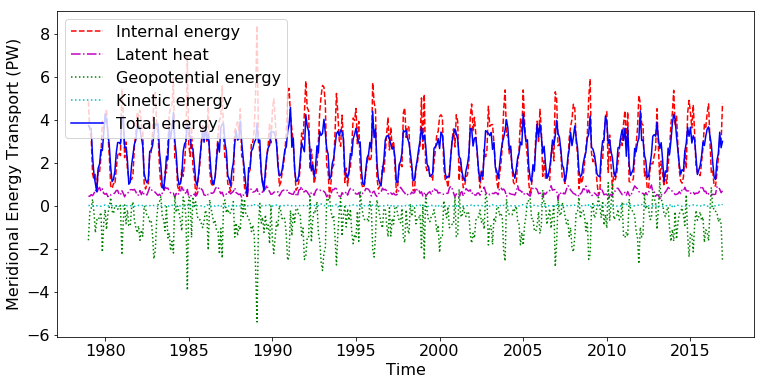

In [6]:
# remove seasonal cycles
# zonal integral
E_seasonal_cycle = np.mean(E,0)
month_ind = np.arange(12)
E_white = np.zeros(E.shape)
for i in month_ind:
    for j in np.arange(len(year)):
        E_white[j,i,:] = E[j,i,:] - E_seasonal_cycle[i,:]
# spacial distribution
E_point_seasonal_cycle = np.mean(E_point,0)
E_point_white = np.zeros(E_point.shape)
for i in month_ind:
    for j in np.arange(len(year)):
        E_point_white[j,i,:,:] = E_point[j,i,:,:] - E_point_seasonal_cycle[i,:,:]

# reshape the array into time series
# original signals
series_E = E.reshape(len(year)*len(month),len(latitude))
series_E_internal = E_internal.reshape(len(year)*len(month),len(latitude))
series_E_latent = E_latent.reshape(len(year)*len(month),len(latitude))
series_E_geopotential = E_geopotential.reshape(len(year)*len(month),len(latitude))
series_E_kinetic = E_kinetic.reshape(len(year)*len(month),len(latitude))
# whiten signals
series_E_white = E_white.reshape(len(year)*len(month),len(latitude))
series_E_point_white = E_point_white.reshape(len(year)*len(month),len(latitude),len(longitude))

# transpose
# original signals
T_series_E = np.transpose(series_E)
T_series_E_internal = np.transpose(series_E_internal)
T_series_E_latent = np.transpose(series_E_latent)
T_series_E_geopotential = np.transpose(series_E_geopotential)
T_series_E_kinetic = np.transpose(series_E_kinetic)
# whiten signals
T_series_E_white = np.transpose(series_E_white)

index = np.arange(1,len(year)*len(month)+1,1)
index_year = np.arange(1980,year[-1]+1,5)
axis_ref = np.zeros(len(index))

# everything in one plot
fig6 = plt.figure()
plt.plot(index,T_series_E_internal[40,:]/1000,'r--',label='Internal energy')
plt.plot(index,T_series_E_latent[40,:]/1000,'m-.',label='Latent heat')
plt.plot(index,T_series_E_geopotential[40,:]/1000,'g:',label='Geopotential energy')
plt.plot(index,T_series_E_kinetic[40,:]/1000,'c:',label='Kinetic energy')
plt.plot(index,T_series_E[40,:]/1000,'b-',label='Total energy')
#plt.title('Atmospheric Meridional Energy Transport time series at %d N (1979-2016)' % (Lat_num))
plt.legend(frameon=True, loc=2, prop={'size': 16})
fig6.set_size_inches(12.5, 6)
plt.xlabel("Time",fontsize=16)
#plt.xticks(np.linspace(0, 456, 39), index_year)
plt.xticks(np.arange(13,len(year)*len(month)+1,60), index_year,fontsize=16)
#plt.xticks(rotation=60)
plt.ylabel("Meridional Energy Transport (PW)",fontsize=16)
plt.yticks(fontsize=16)
plt.show()
fig6.savefig(output_path + os.sep + 'Meridional_Energy_%dN_eachComponent_time_series_1979_2016.png' % (Lat_num), dpi = 300)
